## Time Series Analysis of Financial Asset Price
---
Project notebook organisation:<br>
<a href='./1_SARIMAX.ipynb'>1_SARIMAX</a><br>
<a href='./2_fbProphet.ipynb'>2_fbProphet</a><br>
**3_Vector_AutoRegression** (current notebook)<br>

---
### This notebook's layout
<a href='#dict'>Data dictionary</a><br>
<a href='#import'>Data Import and Cleaning</a><br>
<a href='#gct'>Granger Causality Test</a><br>
<a href='#adf'>Augmented Dickey–Fuller test</a><br>
<a href='#diff'>Time Differencing datasets</a><br>
<a href='#tts'>train test split</a><br>
<a href='#model'>Data Modelling</a><br>
<a href='#rev'>Reverse Time Differencing datasets</a><br>
<a href='#nk'>Stock Indices (sp500 and nikkei) 1 month prediction</a><br>
<a href='#dax'>Stock Indices (sp500 and dax) 1 month prediction</a><br>
<a href='#ftse'>Stock Indices (sp500 and ftse) 1 month prediction</a><br>
<a href='#sum'>Summary of Findings</a><br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('ggplot')
%matplotlib inline
import pandas_datareader.data as web
from pandas.plotting import lag_plot
import yfinance

import datetime as dt
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AR,ARResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
C:\Users\LES\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
C:\Users\LES\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
"""
dax = web.DataReader("^GDAXI", 
                       start='2017-6-1', 
                       end='2020-6-1', 
                       data_source='yahoo')

sp500 = web.DataReader("^GSPC", 
                       start='2017-6-1', 
                       end='2020-6-1', 
                       data_source='yahoo')

nikkei = web.DataReader("^N225", 
                       start='2017-6-1', 
                       end='2020-6-1', 
                       data_source='yahoo')

ftse = yfinance.download (tickers = "^FTSE",
start = "2017-6-1", #The starting date of our data set
end = "2020-6-1", #The ending date of our data set (at the time of 
interval = "1d", #The distance in time between two recorded observations. 
treads = True)
#
dax.to_csv('data/dax.csv')
sp500.to_csv('data/sp500.csv')
nikkei.to_csv('data/nikkei.csv')
ftse.to_csv('data/ftse.csv')
"""

'\ndax = web.DataReader("^GDAXI", \n                       start=\'2017-6-1\', \n                       end=\'2020-6-1\', \n                       data_source=\'yahoo\')\n\nsp500 = web.DataReader("^GSPC", \n                       start=\'2017-6-1\', \n                       end=\'2020-6-1\', \n                       data_source=\'yahoo\')\n\nnikkei = web.DataReader("^N225", \n                       start=\'2017-6-1\', \n                       end=\'2020-6-1\', \n                       data_source=\'yahoo\')\n\nftse = yfinance.download (tickers = "^FTSE",\nstart = "2017-6-1", #The starting date of our data set\nend = "2020-6-1", #The ending date of our data set (at the time of \ninterval = "1d", #The distance in time between two recorded observations. \ntreads = True)\n#\ndax.to_csv(\'data/dax.csv\')\nsp500.to_csv(\'data/sp500.csv\')\nnikkei.to_csv(\'data/nikkei.csv\')\nftse.to_csv(\'data/ftse.csv\')\n'

<a id='import'></a>
### Data Import and Cleaning

In [3]:
# reading-in the data files
dax = pd.read_csv('../data/dax.csv',index_col='Date',parse_dates=True)
sp500 = pd.read_csv('../data/sp500.csv',index_col='Date',parse_dates=True)
nikkei = pd.read_csv('../data/nikkei.csv',index_col='Date',parse_dates=True)
ftse = pd.read_csv('../data/ftse.csv',index_col='Date',parse_dates=True)

In [4]:
# Standarised the first and last row in the datasets
print(sp500.index.max()) # to delete row
print(sp500.index.min())
print()
print(dax.index.max())
print(dax.index.min())
print()
print(ftse.index.max())
print(ftse.index.min())
print()
print(nikkei.index.max()) # to delete row
print(nikkei.index.min()) # to delete row

2020-06-01 00:00:00
2017-05-31 00:00:00

2020-05-29 00:00:00
2017-05-31 00:00:00

2020-05-29 00:00:00
2017-05-31 00:00:00

2020-06-01 00:00:00
2017-06-01 00:00:00


In [5]:
# Dropping nas to Standarised the first and last row in the datasets
sp500.drop(pd.Timestamp('2020-06-01'),inplace=True)
nikkei.drop(pd.Timestamp('2020-06-01'),inplace=True)
nikkei.drop(pd.Timestamp('2017-06-01'),inplace=True)

In [6]:
# Sets date freq to 'b'(business day)
dax = dax.asfreq('b')
sp500 = sp500.asfreq('b')
nikkei = nikkei.asfreq('b')
ftse = ftse.asfreq('b')

In [7]:
# Dropping all unwanted columns
sp500.drop(['High', 'Low', 'Open', 'Adj Close','Volume'], axis=1, inplace = True)
dax.drop(['High', 'Low', 'Open', 'Adj Close','Volume'], axis=1, inplace = True)
nikkei.drop(['High', 'Low', 'Open', 'Adj Close','Volume'], axis=1, inplace = True)
ftse.drop(['High', 'Low', 'Open', 'Adj Close','Volume'], axis=1, inplace = True)

In [8]:
# Re-naming columns by adding prefixes
sp500.columns = ['sp500_' + str(col) for col in sp500.columns]
dax.columns = ['dax_' + str(col) for col in dax.columns]
nikkei.columns = ['nikkei_' + str(col) for col in nikkei.columns]
ftse.columns = ['ftse_' + str(col) for col in ftse.columns]

In [9]:
# Combine all data files into one
indices = pd.concat([sp500, dax, nikkei, ftse], axis=1)

In [10]:
# Check na values after combining
indices.isna().sum()

sp500_Close     28
dax_Close       29
nikkei_Close    53
ftse_Close      24
dtype: int64

In [11]:
# Dropping the na values
indices.dropna(inplace=True)

<a id='eda'></a>
### EDA

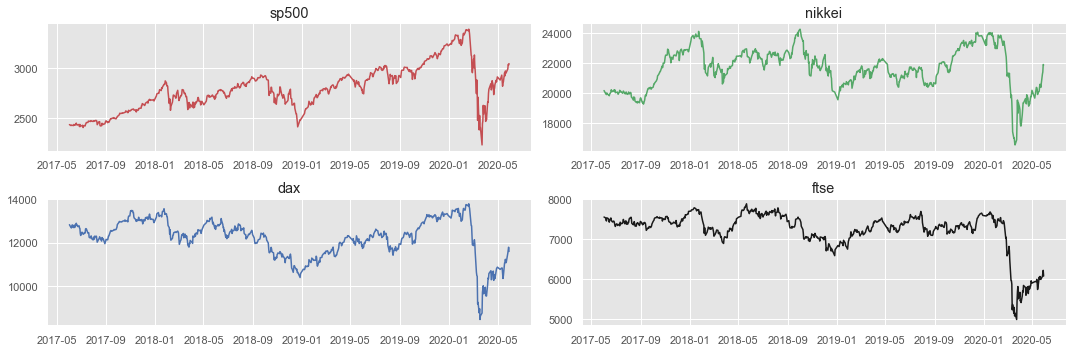

In [12]:
fig, ax = plt.subplots(2, 2,figsize=(15,5))

ax[0, 0].set_title('sp500')
ax[0, 0].plot(indices.sp500_Close, 'r')

ax[1, 0].set_title('dax')
ax[1, 0].plot(indices.dax_Close, 'b')

ax[0, 1].set_title('nikkei')
ax[0, 1].plot(indices.nikkei_Close, 'g')

ax[1, 1].set_title('ftse')
ax[1, 1].plot(indices.ftse_Close, 'k', label='ftse')

plt.tight_layout()
plt.show()

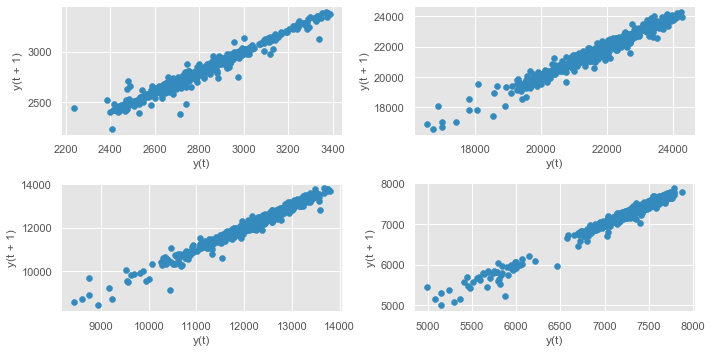

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,5))

lag_plot(indices.sp500_Close,ax=axes[0,0])
lag_plot(indices.dax_Close,ax=axes[1,0])
lag_plot(indices.nikkei_Close,ax=axes[0,1])
lag_plot(indices.ftse_Close,ax=axes[1,1])
plt.tight_layout()
plt.show()

<a id='gct'></a>
### Granger Causality Test

In [14]:
def get_best_gct(gct_output_var, exog_var_name):
    """Returns no. of lags where the p value is lowest"""
    list1=[]
    for nlag in range(1,4,1): # maxlag=3 is standard
        temp_p_value = gct_output_var[nlag][0]['ssr_ftest'][1]
        list1.append(temp_p_value)
    min1 = min(list1) # gets the min value inside list
    min_posn = list1.index(min(list1)) + 1 # Need to plus 1 due to list item length
    print(F'{exog_var_name} minimum P value is {min1} with no.of lag at {min_posn}')

#### Runs GCT test across all 3 pairs of stock market indices

In [15]:
sp500_nikkei = grangercausalitytests(indices[['sp500_Close','nikkei_Close']],maxlag=3,verbose=False);
get_best_gct(sp500_nikkei,'sp500_nikkei')

sp500_nikkei minimum P value is 5.3849877976844356e-05 with no.of lag at 2


In [16]:
sp500_ftse = grangercausalitytests(indices[['sp500_Close','ftse_Close']],maxlag=3,verbose=False);
get_best_gct(sp500_ftse,'sp500_ftse')

sp500_ftse minimum P value is 0.012260289291822286 with no.of lag at 3


In [17]:
sp500_dax = grangercausalitytests(indices[['sp500_Close','dax_Close']],maxlag=3,verbose=False);
get_best_gct(sp500_dax,'sp500_dax')

sp500_dax minimum P value is 6.961767363802071e-05 with no.of lag at 3


In [18]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [19]:
#cointegration_test(indices)

In [20]:
indices.to_csv('../data/indices.csv')

<a id='adf'></a>
### Augmented Dickey–Fuller test

Augmented Dickey–Fuller tests for Stationarity in a time series data<br>

In [21]:
def adf_test(series):
    """Pass in a time series and an optional title, returns an ADF report"""
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis. Data has a unit root and is non-stationary")

In [22]:
adf_test(indices['sp500_Close'])

ADF test statistic       -2.567064
p-value                   0.099997
# lags used               9.000000
# observations          675.000000
critical value (1%)      -3.440075
critical value (5%)      -2.865831
critical value (10%)     -2.569055
Weak evidence against the null hypothesis
Fail to reject the null hypothesis. Data has a unit root and is non-stationary


In [23]:
adf_test(indices['dax_Close'])

ADF test statistic       -2.563293
p-value                   0.100824
# lags used              19.000000
# observations          665.000000
critical value (1%)      -3.440222
critical value (5%)      -2.865896
critical value (10%)     -2.569090
Weak evidence against the null hypothesis
Fail to reject the null hypothesis. Data has a unit root and is non-stationary


In [24]:
adf_test(indices['nikkei_Close'])

ADF test statistic       -3.370072
p-value                   0.012022
# lags used              12.000000
# observations          672.000000
critical value (1%)      -3.440119
critical value (5%)      -2.865851
critical value (10%)     -2.569066
Strong evidence against the null hypothesis
Reject the null hypothesis. Data has no unit root and is stationary


In [25]:
adf_test(indices['ftse_Close'])

ADF test statistic       -1.536851
p-value                   0.515209
# lags used              20.000000
# observations          664.000000
critical value (1%)      -3.440237
critical value (5%)      -2.865903
critical value (10%)     -2.569093
Weak evidence against the null hypothesis
Fail to reject the null hypothesis. Data has a unit root and is non-stationary


In [26]:
# Create 3 dataframes based on the intended pairs to run the model
indices_jp = indices[['sp500_Close','nikkei_Close']]
indices_de = indices[['sp500_Close','dax_Close']]
indices_uk = indices[['sp500_Close','ftse_Close']]

<a id='diff'></a>
### Time Differencing datasets

In [27]:
# Difference by 1 time lag across all 3 dataframes
indices_jp_diff1 = indices_jp.diff()
indices_de_diff1 = indices_de.diff()
indices_uk_diff1 = indices_uk.diff()

#### Checks for stationarity after differencing is done (1 time lag)

In [28]:
adf_test(indices_jp_diff1['sp500_Close'])

ADF test statistic     -7.529431e+00
p-value                 3.611372e-11
# lags used             8.000000e+00
# observations          6.750000e+02
critical value (1%)    -3.440075e+00
critical value (5%)    -2.865831e+00
critical value (10%)   -2.569055e+00
Strong evidence against the null hypothesis
Reject the null hypothesis. Data has no unit root and is stationary


In [29]:
adf_test(indices_de_diff1['dax_Close'])

ADF test statistic     -6.592092e+00
p-value                 7.072770e-09
# lags used             1.800000e+01
# observations          6.650000e+02
critical value (1%)    -3.440222e+00
critical value (5%)    -2.865896e+00
critical value (10%)   -2.569090e+00
Strong evidence against the null hypothesis
Reject the null hypothesis. Data has no unit root and is stationary


In [30]:
adf_test(indices_jp_diff1['nikkei_Close'])

ADF test statistic     -1.075469e+01
p-value                 2.611208e-19
# lags used             6.000000e+00
# observations          6.770000e+02
critical value (1%)    -3.440046e+00
critical value (5%)    -2.865819e+00
critical value (10%)   -2.569049e+00
Strong evidence against the null hypothesis
Reject the null hypothesis. Data has no unit root and is stationary


In [31]:
adf_test(indices_uk_diff1['ftse_Close'])

ADF test statistic     -6.405754e+00
p-value                 1.945217e-08
# lags used             1.900000e+01
# observations          6.640000e+02
critical value (1%)    -3.440237e+00
critical value (5%)    -2.865903e+00
critical value (10%)   -2.569093e+00
Strong evidence against the null hypothesis
Reject the null hypothesis. Data has no unit root and is stationary


In [32]:
# After differencing by 1, there is an NA on the first row, drop it.
indices_jp_diff1.dropna(inplace=True)
indices_de_diff1.dropna(inplace=True)
indices_uk_diff1.dropna(inplace=True)

In [33]:
# dataframe shape[0] is 685 (3 years daily data)
# 685 divide by 36(months) = 19 appr(19 business days per month)
# 
# num of observations
nobs = 19

<a id='tts'></a>
## Train Test Split

In [34]:
# Creates 3 different sets train/test data based on the 3 dataframes
train_jp = indices_jp_diff1[:-nobs] # Start: Begining; End: reverse 19 steps from very end and make it the end point
test_jp = indices_jp_diff1[-nobs:] #  Start: reverse 19 steps from very end and make it the start point; End: The end of df

train_de = indices_de_diff1[:-nobs] 
test_de = indices_de_diff1[-nobs:]

train_uk = indices_uk_diff1[:-nobs] 
test_uk = indices_uk_diff1[-nobs:]

<a id='model'></a>
### Data Modelling

In [35]:
# Run 3 models in a loop(double) to check the VAR model best specs

model_jp = VAR(train_jp)
model_de = VAR(train_de)
model_uk = VAR(train_uk)

model_list = [model_jp,model_de,model_uk]

for md in model_list:
    for p in [1,2,3,4,5]:
        results = md.fit(p)
        print('Order =', p)
        print('AIC: ', results.aic)
        print('BIC: ', results.bic)
        print()

Order = 1
AIC:  17.9143425947592
BIC:  17.954989722615917

Order = 2
AIC:  17.89957973188977
BIC:  17.967404392375226

Order = 3
AIC:  17.903570155280562
BIC:  17.99863619422787

Order = 4
AIC:  17.915347647351858
BIC:  18.037719158875806

Order = 5
AIC:  17.92089749181449
BIC:  18.070638819648504

Order = 1
AIC:  16.591563593862052
BIC:  16.632210721718767

Order = 2
AIC:  16.536315544790167
BIC:  16.604140205275623

Order = 3
AIC:  16.54443372329274
BIC:  16.63949976224005

Order = 4
AIC:  16.544181485418644
BIC:  16.666552996942592

Order = 5
AIC:  16.54198953314837
BIC:  16.691730860982386

Order = 1
AIC:  15.244280517390955
BIC:  15.28492764524767

Order = 2
AIC:  15.202967756154859
BIC:  15.270792416640317

Order = 3
AIC:  15.203682309770514
BIC:  15.298748348717822

Order = 4
AIC:  15.206905012151811
BIC:  15.329276523675759

Order = 5
AIC:  15.209585477009641
BIC:  15.359326804843658



#### Summarising and selecting best lag order based on best AIC/BIC scores
model_jp, lag order = 3, lowest AIC = 17.90<br>
model_de, lag order = 2, lowest AIC = 16.53<br>
model_uk, lag order = 2, lowest AIC = 15.20<br>

In [36]:
# Fitting the 3 models
results_jp = model_jp.fit(2)
results_de = model_de.fit(2)
results_uk = model_uk.fit(2)

In [37]:
# We need to grab x(2 or 3) values based on the model
# grab x lagged values right before test starts, get it from the last x rows of the train
lagged_jp = train_jp.values[-2:] # the p value we need
lagged_de = train_de.values[-2:] # the p value we need
lagged_uk = train_uk.values[-2:] # the p value we need

In [38]:
# p = 2 (lag value)
# k = 2 (always 2 because we run a two variable VAR)
# p * k
# jp: 2*2
# de: 2*2
# uk: 2*2

fcast36_jp = results_jp.forecast(y = lagged_jp, steps= 19)
fcast36_de = results_de.forecast(y = lagged_de, steps= 19)
fcast36_uk = results_uk.forecast(y = lagged_uk, steps= 19)

In [39]:
# Creating a placeholder df. idx is the common date column to be used across 3 placeholder df
# Periods = 36 corresponds to the test length
# Each placeholder df 'holds' the forecasted data for the respective pair
# Forecasted values are time differenced by 1 and we will reverse it in the next step

idx = pd.date_range('2020-04-24',periods=19,freq='b')

df_forecast_jp = pd.DataFrame(data=fcast36_jp,index=idx,columns=['sp500_Close_1d','nikkei_Close_1d'])
df_forecast_de = pd.DataFrame(data=fcast36_de,index=idx,columns=['sp500_Close_1d','dax_Close_1d'])
df_forecast_uk = pd.DataFrame(data=fcast36_uk,index=idx,columns=['sp500_Close_1d','ftse_Close_1d'])

<a id='rev'></a>
### Reverse Time Differencing datasets

#### Understanding the process of reversing time difference

Before we get into reversing the time diff, we need understanding here the focus is on the test data<br>
test data shape is 19.<br>

We take the first line of code as an example

<img src="../misc/understand_time_diff.jpg" width="650" align="left">

In [40]:
df_forecast_jp['sp500_Close'] = (indices_jp['sp500_Close'].iloc[-nobs-1]) + df_forecast_jp['sp500_Close_1d'].cumsum()
df_forecast_jp['nikkei_Close'] = (indices_jp['nikkei_Close'].iloc[-nobs-1]) + df_forecast_jp['nikkei_Close_1d'].cumsum()

df_forecast_de['sp500_Close'] = (indices_de['sp500_Close'].iloc[-nobs-1]) + df_forecast_de['sp500_Close_1d'].cumsum()
df_forecast_de['dax_Close'] = (indices_de['dax_Close'].iloc[-nobs-1]) + df_forecast_de['dax_Close_1d'].cumsum()

df_forecast_uk['sp500_Close'] = (indices_uk['sp500_Close'].iloc[-nobs-1]) + df_forecast_uk['sp500_Close_1d'].cumsum()
df_forecast_uk['ftse_Close'] = (indices_uk['ftse_Close'].iloc[-nobs-1]) + df_forecast_uk['ftse_Close_1d'].cumsum()

<a id='nk'></a>
### Stock Indices (sp500 and nikkei) 1 month prediction

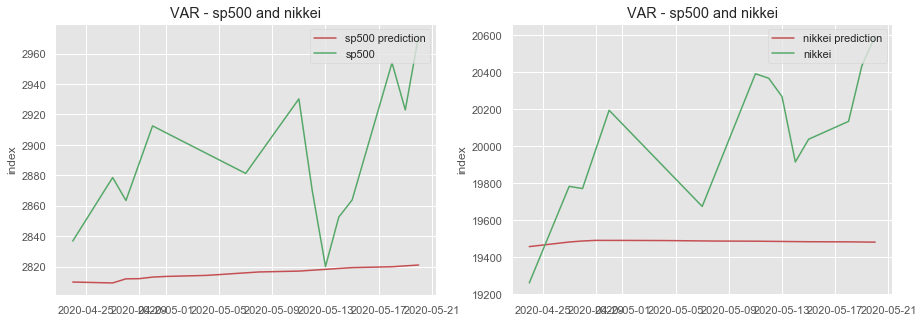

In [41]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

axes[0].plot(df_forecast_jp['sp500_Close'], color='r', label = 'sp500 prediction')
axes[0].legend(loc=0) 
axes[0].set_title('VAR - sp500 and nikkei')
axes[0].set_ylabel('index') 
axes[0].plot(indices_jp['sp500_Close']['2020-04-24':'2020-05-20'], color='g', label = 'sp500')
axes[0].legend(loc=1)

axes[1].plot(df_forecast_jp['nikkei_Close'], color='r', label='nikkei prediction')
axes[1].legend(loc=0)
axes[1].legend(['nikkei_prediction']) 
axes[1].set_title('VAR - sp500 and nikkei')
axes[1].set_ylabel('index')
axes[1].plot(indices_jp['nikkei_Close']['2020-04-24':'2020-05-20'], color='g',label = 'nikkei')
axes[1].legend(loc=1)

plt.show()

<a id='dax'></a>
### Stock Indices (sp500 and dax) 1 month prediction

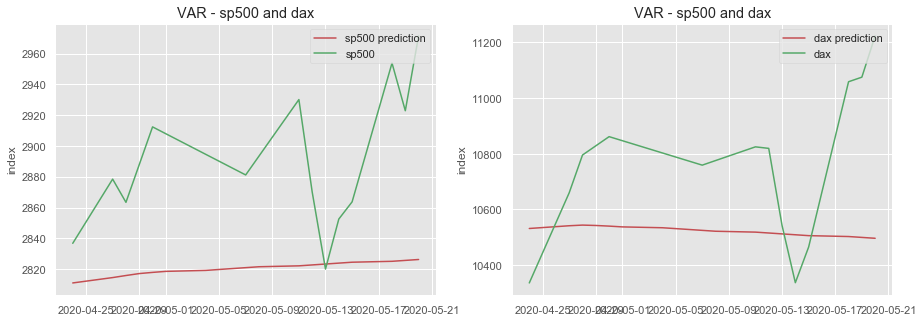

In [42]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

axes[0].plot(df_forecast_de['sp500_Close'], color='r', label = 'sp500 prediction')
axes[0].legend(loc=0) 
axes[0].set_title('VAR - sp500 and dax')
axes[0].set_ylabel('index') 
axes[0].plot(indices_de['sp500_Close']['2020-04-24':'2020-05-20'], color='g', label = 'sp500')
axes[0].legend(loc=1)

axes[1].plot(df_forecast_de['dax_Close'], color='r', label='dax prediction')
axes[1].legend(loc=0)
axes[1].legend(['dax_prediction']) 
axes[1].set_title('VAR - sp500 and dax')
axes[1].set_ylabel('index')
axes[1].plot(indices_de['dax_Close']['2020-04-24':'2020-05-20'], color='g',label = 'dax')
axes[1].legend(loc=1)

plt.show()

<a id='ftse'></a>
### Stock Indices (sp500 and ftse) 1 month prediction

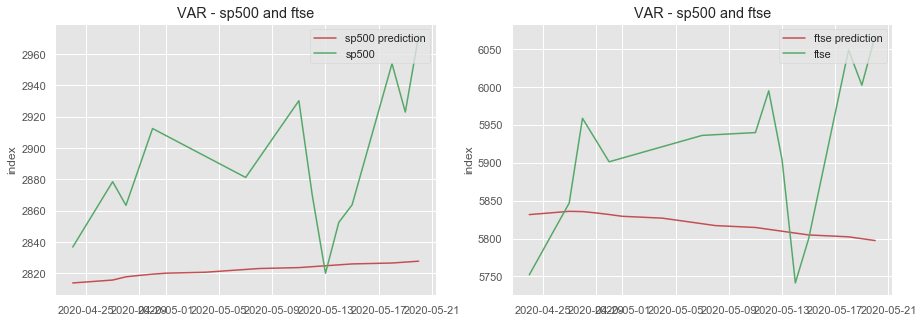

In [43]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

axes[0].plot(df_forecast_uk['sp500_Close'], color='r', label = 'sp500 prediction')
axes[0].legend(loc=0) 
axes[0].set_title('VAR - sp500 and ftse')
axes[0].set_ylabel('index') 
axes[0].plot(indices_uk['sp500_Close']['2020-04-24':'2020-05-20'], color='g', label = 'sp500')
axes[0].legend(loc=1)

axes[1].plot(df_forecast_uk['ftse_Close'], color='r', label='ftse prediction')
axes[1].legend(loc=0)
axes[1].legend(['ftse_prediction']) 
axes[1].set_title('VAR - sp500 and ftse')
axes[1].set_ylabel('index')
axes[1].plot(indices_uk['ftse_Close']['2020-04-24':'2020-05-20'], color='g',label = 'ftse')
axes[1].legend(loc=1)

plt.show()

In [44]:
# Just looking at RMSE value is unless, we need to compare RMSE with a mean to get a sense of the value
sp500_avg = indices_jp['sp500_Close'][-nobs:].mean()
nikkei_avg = indices_jp['nikkei_Close'][-nobs:].mean()
dax_avg = indices_de['dax_Close'][-nobs:].mean()
ftse_avg = indices_uk['ftse_Close'][-nobs:].mean()

In [45]:
# Prints out the RMSE errors
RMSE1 = rmse(indices_jp['sp500_Close'][-nobs:], df_forecast_jp['sp500_Close'])
print(f'sp500 VAR(2) RMSE: {RMSE1:.3f}')
print(f'sp500 avg: {sp500_avg:.3f}')
RMSE2 = rmse(indices_jp['nikkei_Close'][-nobs:], df_forecast_jp['nikkei_Close'])
print(f'nikkei VAR(2) RMSE: {RMSE2:.3f}')
print(f'nikkei avg: {nikkei_avg:.3f}')
print()
RMSE1 = rmse(indices_de['sp500_Close'][-nobs:], df_forecast_de['sp500_Close'])
print(f'sp500 VAR(2) RMSE: {RMSE1:.3f}')
print(f'sp500 avg: {sp500_avg:.3f}')
RMSE2 = rmse(indices_de['dax_Close'][-nobs:], df_forecast_de['dax_Close'])
print(f'dax VAR(2) RMSE: {RMSE2:.3f}')
print(f'dax avg: {dax_avg:.3f}')
print()
RMSE1 = rmse(indices_uk['sp500_Close'][-nobs:], df_forecast_uk['sp500_Close'])
print(f'sp500 VAR(2) RMSE: {RMSE1:.3f}')
print(f'sp500 avg: {sp500_avg:.3f}')
RMSE2 = rmse(indices_uk['ftse_Close'][-nobs:], df_forecast_uk['ftse_Close'])
print(f'ftse VAR(2) RMSE: {RMSE2:.3f}')
print(f'ftseavg: {ftse_avg:.3f}')

sp500 VAR(2) RMSE: 126.312
sp500 avg: 2924.374
nikkei VAR(2) RMSE: 1180.769
nikkei avg: 20434.143

sp500 VAR(2) RMSE: 121.979
sp500 avg: 2924.374
dax VAR(2) RMSE: 622.254
dax avg: 10969.997

sp500 VAR(2) RMSE: 120.673
sp500 avg: 2924.374
ftse VAR(2) RMSE: 200.118
ftseavg: 5968.879


<a id='sum'></a>
### `Summary of Findings:`

<img src="../misc/var_summary_table.jpg" width="1000" align="left">